## Global Suicide Analysis & Prediction Model ##
This project takes in the ['Suicide Rates Overview 1985 to 2016' dataset](https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016), which itself is 'pulled from four other datasets', referenced as below in the dataset description: 

1. United Nations Development Program. (2018). Human development index (HDI). Retrieved from http://hdr.undp.org/en/indicators/137506

2. World Bank. (2018). World development indicators: GDP (current US$) by country: 1985 to 2016. Retrieved from http://databank.worldbank.org/data/source/world-development-indicators

3. Szamil. (2017). Suicide in the Twenty-First Century [dataset]. Retrieved from https://www.kaggle.com/szamil/suicide-in-the-twenty-first-century/notebook

4. World Health Organization. (2018). Suicide prevention. Retrieved from http://www.who.int/mental_health/suicide-prevention/en/

At a later stage, we merge this dataset with two other datasets to identify potential signals that may be useful for creating a ML model to predict suicide rates in the future as well as for missing countries.

1. [CIA World Fact Sheet](https://www.kaggle.com/fernandol/countries-of-the-world), which continues 'information on population, region, area size, infant mortality and more'.
2. [Correlates of War: World Religions](https://www.kaggle.com/umichigan/world-religions) by University of Michigan

**Disclaimer:** All attempt has been made to utilize the datasets in this project in good faith as per the source's data use policy. None of the organisations directly or indirectly mentioned taking any responsibility for the accuracy of the dataset nor for the integrity of the analysis and predictions made below.

### Problem Statement ###

As per the World Health Organization (WHO), almost 800,000 people die every year from suicides. An even more alarming statistic? There are 20 attempts for each suicide that takes place.

Suicide prevention has been identified as a primary health objective by major health organizations including the WHO. The last available data on global suicide rates by core demographic stratas (gender, age) is from 2016. The dataset we will use contains dataset from 1985 to 2016 for `101` countries.

A look at the World Health Organization website shows that the organization has data for most countries from 2016. There are also updated estimates from 2019, but there is very little information available on the source and estimation procedures here.

This provides us an opportunity to independentally analyze the suicide the rates for the `101` countries that we do have the data for by finding relevant socio-economic signals from other datasets. If we do find enough features that are statistically significant, we will attempt to create a model to predict the critical **suicide per 100,000 persons** metric for the other countries. We can then compare this map with the one on WHO to see how accurate our own estimates are vis a vis the WHO dataset.

Some questions that we form a integral driving force for our analysis:

1. Which socio-economic indicators have significant correlation with global suicide rates?
2. Does religion seem to be a relevant factor in predicting suicide rates?

In [ ]:
%matplotlib inline

import numpy as np 
import pandas as pd 

# import libraries for graph generations and mapping geodata
import matplotlib.pyplot as plt
import geoplot
import mapclassify
import seaborn as sns
import geopandas as gpd

# import the quintessential ML modules
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestRegressor

# we will use SequenceMatcher to quickly merge datasets by country code
from difflib import SequenceMatcher

# since our dataset isn't too large, we'll set the column/row display limits accordingly.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
np.set_printoptions(suppress=True)

# let's import our datasets
## key dataset with suicide rates and basic socio-economic data
suicide = pd.read_csv('/kaggle/input/suicide-rates-from-1986-to-2016/suicide.csv')
## country-wise religions by both sum and percentage
religion = pd.read_csv('/kaggle/input/world-religions/national.csv')
## 'Countries of the World' dataset aka the World Factbook
cotw = pd.read_csv('/kaggle/input/countries-of-the-world/countries of the world.csv')


# default kaggle code that highlights all of the files in our directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        


In [ ]:
suicide.head()

In [ ]:
# change 'Republic of Korea' to 'South Korea' to remove any confusion.
suicide['country'] = suicide['country'].replace(['Republic of Korea'], 'South Korea')

## Analyzing Dataset: Canada in focus ##

To understand the overall data structure, let's look at a country in particular. We look at Canada in detail as that is where the author is located and it helps provide context and comparisons for the researcher when looking at regional and global data in the next steps.

In [ ]:
canada = suicide[suicide['country'] == 'Canada']

canada.head()

In [ ]:
# let's analyze year-by-year suicides per 100k pop

can_pivot_sex = canada.pivot_table(columns=['sex'], index=['year'], values=['suicides/100k pop'], aggfunc=np.sum)
years = [col[1] for col in can_pivot_sex.columns]

can_pivot_sex

### Canada: Gender-based Suicide Rate ###

Historically, men are over 3 times more likely to commit suicide vis a vis women in Canada. There has been a gradual but significant narrowing within this gap. Suicide rates for women are relatively stable but have decreased gradually for men.

In [ ]:
can_pivot_sex.plot(figsize=(5,3))

### Canada: Age-based Suicide Rate ###

Since the early 90's, the 35-44 age group has higher suicide rates - this gap has continued to widen. This is partly due to a more noticable drop in suicide rates for other age groups over the last 25 years.

In [ ]:
can_pivot_age = canada.pivot_table(columns=['age'], index=['year'], values=['suicides/100k pop'], aggfunc=np.sum)

can_pivot_age

In [ ]:
can_pivot_age.plot()

## Cleaning & Preparation of `Suicide` Dataset ##

There is a noticable dropoff of countries on a year-by-year basis. For example, 2014 has data for `78` countries whereas 2013 has `80` countries. The number of countries in 2015 are only `62`, which is a considerable dropoff. We will therefore focus on the year `2014` in our analysis and model.

*The non-availability of historical data for the countries not present in the `Suicide` dataset prevents us from using time series analysis for making future predictions for missing countries, which is one of our key objectives.*

**If we find a handful of statistically significant features, we will limit our model to finding the suicide rates for the missing countries the `suicide` dataset.**

In [ ]:
# we will limit the dataset to 2014 as stated in the description above.
suicide_2014 = suicide[suicide['year'] == 2014]

# let's confirm that there are 78 countries in this dataset.
suicide_2014['country'].nunique()

In [ ]:
# let's aggregate the dataset as per the relevant columns
# the aggregation function for HDI will need be `np.mean` whereas for the others it will be `np.sum`

pivot_dict = {'suicides_no': np.sum,
             'population': pd.Series.mode,
             'HDI for year': np.mean,
             'gdp_per': pd.Series.mode}

suicide_2014 = suicide_2014.pivot_table(['suicides_no', 'population', 'HDI for year', 'gdp_per_capita ($)'],
                                        index=['country'], aggfunc= 
                                        {'suicides_no': np.sum, 'population': np.sum, 'HDI for year': np.mean,
                                        'gdp_per_capita ($)': np.mean})

suicide_2014

In [ ]:
# Let's calculate the 'suicide rate per 100k'on our own instead of concatenating the original column to our post-pivot table
suicide_2014['suicides_100k'] = suicide_2014['suicides_no'] / suicide_2014['population'] * 100000

# further exploratory study: should we remove the countries with `0` suicide rates - will they skew the data?


In [ ]:
# we will create a function to find the code from the `wikipedia-iso-country-codes` dataset. 
# to do that, the function first uses a `SequenceMatcher` to match the country names in both datasets.

def code_finder(df, col):
    c_codes = pd.read_csv('/kaggle/input/iso-country-codes-global/wikipedia-iso-country-codes.csv')
    countries = []
    codes = []
    for country in col:
        highest_score = 0
        idx = 0
        for c in c_codes['English short name lower case']:
            score = SequenceMatcher(None, country, c).ratio()
            if score > highest_score:
                highest_score = score
                best_match = c
                code = c_codes.iloc[idx,2]
            idx += 1
        countries.append(country)
        codes.append(code)
    return countries, codes

countries, codes = code_finder(suicide_2014, suicide_2014.index)

# let's create a dataframe to depict the findings and merge them conveniently
codes_df = pd.DataFrame(index=countries)
codes_df['codes'] = codes

codes_df

In [ ]:
merged_df = suicide_2014.merge(codes_df, how='left', left_index=True, right_index=True)
merged_df.head(10)

In [ ]:
# moving forward, we will use the country code as our index, particularly as it will make 
# our job easier working with geopandas
merged_df.set_index('codes', inplace=True)
merged_df.head(10)

## Visualizing Suicide Rates Globally ##

We visually observe global suicide rates for the available countries in our dataset through a chloropleth map. Some key observations with regards to the visual data uncovered are as below:

* We have minimal information with regards to Africa and South Asia. This means that while regional data (continent, subregion) may still be useful, we will need a handful statistically significant features other than geographical ones to strengthen our model.
* Mackinder's heartland, which refers to Russia, Eastern Europe and some Central Asian states (all former Soviet bloc states) have the highest suicide rates from the available data.
* Canada, which we studied in detail earlier, is likely missing here due to absent data for 2014.
* In the future, we should seriously consider developing a pipeline in which we can manually enter the year (to incorporate more countries) and see how our results differ.





In [ ]:
# let's save our target column (for the map) to a variable
variable = 'suicides_100k'

shape_file = "../input/world-shapefiles/ne_10m_admin_0_countries.shp"
map_df = gpd.read_file(shape_file)


In [ ]:
# Join chloropleth map data with our dataset
map_df = map_df.set_index('ADM0_A3').join(merged_df)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,12))
map_df.plot(variable, cmap='coolwarm', linewidth=0.8, ax=ax, legend=True,  edgecolor="gray")

## Merging Socio-Economic Indicators For All Countries  ##

In [ ]:
df = merged_df.copy()

In [ ]:
# let's merge the CIA Factbook data with our dataset. 
# note that we need to set the 'Country' column as the index as our `code_finder` function works with the index.

cotw.set_index('Country', inplace=True)

In [ ]:
countries, codes = code_finder(cotw, cotw.index)
cotw['codes'] = codes
cotw['country'] = countries

In [ ]:
merged_df2 = df.join(cotw.set_index('codes'), how='outer')
merged_df2 = merged_df2[~merged_df2.index.duplicated(keep='first')]

# train = merged_df2[~merged_df2['suicides_100k'].isnull()]
# train.shape

In [ ]:
df = merged_df2.copy()

In [ ]:
df['Region'] = df['Region'].str.strip()
df['country'] = df['country'].str.strip()
df.head()

In [ ]:
# let's add country-wise religious data with our dataset
# we'll extract the data from 2010 as that those represent latest available figures for our for all countries on our initial dataset (`suicide`))

# set 'state' as index to enable usability with `code_finder` function
religion_2010 = religion[religion['year'] == 2010]
religion_2010.set_index('state', inplace=True)

countries, codes = code_finder(religion_2010, religion_2010.index)
religion_2010['codes'] = codes

In [ ]:
religion_2010['state'] = religion_2010.index
religion_2010.set_index('codes', inplace=True)

In [ ]:
# before merging, find any column that intersect between both data sets
df_cols = set(df.columns)
religion_cols = set(religion_2010.columns)
col_intersect = set.intersection(df_cols, religion_cols)

# one culprit found: 'population'
religion_2010.drop('population', axis=1, inplace=True)

In [ ]:
religion_2010 = religion_2010[~religion_2010.index.duplicated(keep='first')]

In [ ]:
# merge df with religion data
merged_df3 = df.join(religion_2010, how='left')
merged_df3

#merged_df3 = merged_df3[~merged_df3.index.duplicated(keep='last')]
#merged_df3[~merged_df3['suicides_100k'].isnull()]

In [ ]:
# we can see that 'South Korea' and 'Puerto Rico' have zero HDI. 
# let's replace these with real world values from 2014.

merged_df3.loc['KOR','HDI for year'] = 0.896
merged_df3.loc['PRI','HDI for year'] = 0.845

In [ ]:
# let's create a new dataset so we can easily revert to this state if required
df = merged_df3.copy()

df

In [ ]:
# let's identify and clean columns that require preparation

clean_cols = [
    'Pop. Density (per sq. mi.)', 'Arable (%)', 'Coastline (coast/area ratio)', 'Net migration',
    'Infant mortality (per 1000 births)', 'Literacy (%)', 'Phones (per 1000)',
    'Phones (per 1000)', 'Crops (%)','Other (%)','Birthrate','Deathrate',
    'Agriculture','Industry','Climate', 'Service' ]

def cleaner(val):
    out = str(val).replace(',','.')
    out = float(out)
    return out

for c in clean_cols:
    df[c] = df[c].map(lambda x: cleaner(x), na_action='ignore')

### Handle Missing Data ### 

In [ ]:
df.loc['PRI','state'] = 'Puerto Rico'
df['Climate'] = df['Climate'].astype(float)

In [ ]:
df.isnull().sum()

In [ ]:
null_cols = set(df.isnull().sum().sort_values().index)
numeric_columns = set(df.select_dtypes(np.number).columns)
null_cols = set.intersection(null_cols, numeric_columns)
null_cols.remove('suicides_100k')
null_cols

In [ ]:
# let's deal with numerical null values
# finding region-wise mean values for all empty columns for easy extraction 
df_pivot_region = df.pivot_table(null_cols, 'Region', aggfunc=np.mean)
df_pivot_region.head()

In [ ]:
df_pivot_region.loc['NORTHERN AFRICA']['HDI for year'] = .775
df_pivot_region

In [ ]:
# let's fill in the null values
def na_filler(df):
    # we iterate through each column that contains null values
    for col in null_cols:
        
        # extract all null value indexes for each column
        idx = df.Region[df.isnull()[col]].index
        
        # find out the `Region` value for each null value in each column
        region = df.Region[df.isnull()[col]]
        
        # find the mean value from our pivot table by indexing by region and column
        result = df_pivot_region.loc[region][col]
        
        #create a dictionary with index as key and region-based mean as value through dictionary comprehension
        result_dict = {idx[i]: result[i] for i in range(len(idx))}
        
        # assign result to missing values
        df[col] = df[col].fillna(result_dict)
    
na_filler(df)
        

### Regional Distribution of Suicide Rates ###

Let's take a quick peek into the regional distribution of suicide rates with a box-and-whisker plot. As we can see, there is clearly very little data for `North America` and `Oceania`.

In [ ]:
train = df[~df['suicides_100k'].isnull()]
sns.boxplot(x='suicides_100k', y='Region', data=train, fliersize=5)
plt.xticks(rotation=45)

In [ ]:
regions = pd.get_dummies(df['Region'])
df = df.merge(regions, left_index=True, right_index=True)
df.head()

In [ ]:
# Let's see which columns have a high correlation with our target variable of 'suicides_100k'
corr = df.corr()['suicides_100k'].sort_values(ascending=False)
corr

In [ ]:
# as expected from such a complex phenomenon like suicide, there is no feature that shows high correlation with our target variable
# let's try remove columns that may introduce excess noise when predicting suicide rates for missing countries

columns_significant_corr = list(corr.index[(corr > .17) | (corr < -.17)])
columns_significant_corr.append('state')

df = df.loc[:,columns_significant_corr]
df


In [ ]:
# lets plot a headmap to see correlations visually
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr())

## Devising A ML Model ##

Let's try to develop and train a ML model that can help us predict the suicide rates for the remaining countries that are missing from our initial dataset. 

In [ ]:
df.columns

In [ ]:
# let's remove columns we will not be needing in our machine learning model

# remove `suicide_no` we dont have any suicide data for data
# remove all non-percent religious columns so as not to overlap percentage columns
# we'll remove the 'shia' and 'sunni' columns and leave in the 'islam' column, as the latter is the sum of the prior two for several countries.
del_columns = ['confucianism_all', 'suicides_no', 'noreligion_all',
               'christianity_easternorthodox','ibadhi_percent', 
               'islam_ibadhi','shi’a_percent', 'sunni_percent', 'otherislam_percent', 'ibadhi_percent',
              'Other (%)']

df.drop(del_columns, axis=1, inplace=True)

In [ ]:
df1 = df[~df['suicides_100k'].isnull()]
df2 = df[df['suicides_100k'].isnull()]

df_ml = pd.concat([df1, df2], axis=0)
print(df.shape, df_ml.shape)


In [ ]:
# to make our job easier for slicing, let's reset the index
df_ml.reset_index(inplace=True)
codes = df_ml['codes']
df_ml.head()

In [ ]:
# slice our target variable for the train dataset
train_y = df_ml.loc[:77, 'suicides_100k']

In [ ]:
df_ml.drop(['codes', 'state', 'suicides_100k'], axis=1, inplace=True)
df_ml.head()

In [ ]:
# make a new copy of the dataset for normalization and training
df_normalized = df_ml.copy()

In [ ]:
# normalize dataset
normalizer = Normalizer()
df_normalized = normalizer.fit_transform(df_normalized)
df_normalized.shape

In [ ]:
# let's create train and test sets
train_X = df_normalized[:78,:]
test_X = df_normalized[78:,:]

### Using `RandomForestRegressor()` To Estimate Suicide Rates For Missing Countries ###

In [ ]:
# we'll use the RandomForestRegressor() to estimate the values for the missing countries
rf = RandomForestRegressor()
model = rf.fit(train_X, train_y)
result = model.predict(test_X)

In [ ]:
predict_df = df_ml.copy()
predict_df['codes'] = codes
predict_df.loc[:78,'suicides_100k'] = train_y
predict_df.loc[78:,'suicides_100k'] = result
predict_df.head()

### Visualizing and Comparing Results ###

In [ ]:
# finally, let's visualize our map and compare it to the one available from `Our World in Data` that uses the same core dataset to see how far off we are.
variable = 'suicides_100k'
map_df = gpd.read_file(shape_file)

# drop Antartica from the shapefile
map_df.drop(172, axis=0, inplace=True)

merged_df = map_df.set_index('ADM0_A3').join(predict_df.set_index('codes'))

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))
merged_df.plot(variable, cmap='Blues', linewidth=0.8, ax=ax, legend=True, edgecolor="gray")

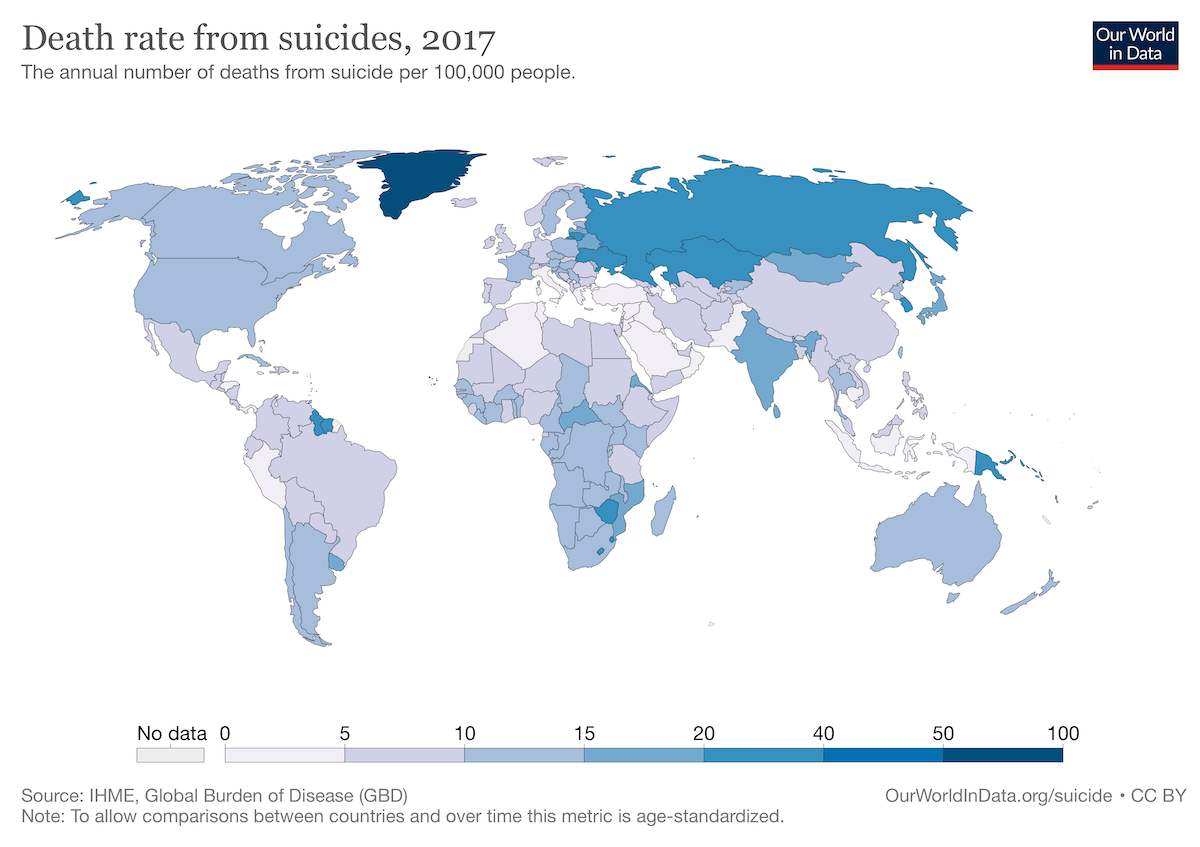

## Analyzing The Results ##

Two obvious discrepencies between our ML driven estimation and the Our World in Data stat sheet are India and Greenland. This makes sense, as none of the reasons generally attributed the high suicides rates for Greenland (low sunlight, loneliness, etc.) are within our features. Infact, Greenland is a real world anomaly, with twice the suicide rate of the next country on the list. India, too, is a regional anomaly and it will always be tough predicting the suicide rate for exceptions, particularly with a limited non-linear data that we had in our data set.

**Another factor to consider:** how much have trends changed since our year of focus (2010) and 2017.

Some more questions that worthy of further analysis:

* There is a strong positive correlation between 'no religion' and suicide rates, what does contemporary academic literature have to say about this?
* The percent of muslims seem to have a negative correlation with suicide rates. Is this due to poor reporting / data collection in these countries or are their deeper reasons driven by faith and social norms.
* If the above two observations merit a closer look, what has been the trend in global suicide rates over the last 30 years in countries where both atheism/agnosticism and Islam are on the rise (primarily European countries?)